# Import

In [1]:
import pandas as pd
import numpy as np
import os
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')

In [2]:
def seed_all(seed: int = 1930):

    print("Using Seed Number {}".format(seed))

    os.environ["PYTHONHASHSEED"] = str(seed)  
    np.random.seed(seed) 
    random.seed(seed)
    
seed_all(seed=1994)

Using Seed Number 1994


# Data load

In [3]:
train = pd.read_csv('train_for_cbr.csv')
test = pd.read_csv('test_cbr.csv')

In [4]:
X_train = train.drop(['target', 'road_in_use', 'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude', 'base_date'], axis=1)
test.drop(['road_in_use', 'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude', 'base_date'], axis=1, inplace=True)
y_train = train['target']

In [21]:
X_train.columns

Index(['day_of_week', 'base_hour', 'lane_count', 'road_rating', 'road_name',
       'multi_linked', 'connect_code', 'maximum_speed_limit',
       'weight_restricted', 'height_restricted', 'road_type',
       'start_node_name', 'start_turn_restricted', 'end_node_name',
       'end_turn_restricted', '제주 강수량', '제주 적설', '고산 강수량', '고산 적설', '성산 강수량',
       '성산 적설', '서귀포 강수량', '서귀포 적설', 'day_of_year', 'holidays'],
      dtype='object')

In [13]:
X_train.head()

,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,height_restricted,...,제주 강수량,제주 적설,고산 강수량,고산 적설,성산 강수량,성산 적설,서귀포 강수량,서귀포 적설,day_of_year,holidays
1374670,0.4338837391175582,-0.7071067811865477,2,103,일반국도12호선,0,0,50.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.8311706263658084,0
3432099,-0.7818314824680299,-0.8660254037844386,2,103,일반국도12호선,0,0,70.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.2636654927280072,1
914521,-0.9749279121818236,-0.2588190451025203,2,103,일반국도12호선,0,0,70.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.1031016974474354,1
3285608,0.0,0.0,2,107,-,0,0,60.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.858763958275803,0
3137530,0.7818314824680298,-0.8660254037844386,2,103,일반국도12호선,0,0,50.0,0.0,0.0,...,0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4093559588156217,0


In [6]:
test.head()

,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,height_restricted,...,제주 강수량,제주 적설,고산 강수량,고산 적설,성산 강수량,성산 적설,서귀포 강수량,서귀포 적설,day_of_year,holidays
0,0.433884,-9.659258e-01,3,107,연삼로,0,0,70.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.806480,0
1,0.781831,1.224647e-16,2,103,일반국도12호선,0,0,70.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.615285,0
2,-0.433884,5.000000e-01,1,103,일반국도16호선,0,0,60.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.559589,0
3,0.433884,-2.588190e-01,3,103,일반국도11호선,0,0,70.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.729558,0
4,0.974928,-9.659258e-01,3,106,번영로,0,0,70.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.628763,0


# train test split

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# Plot learning curve

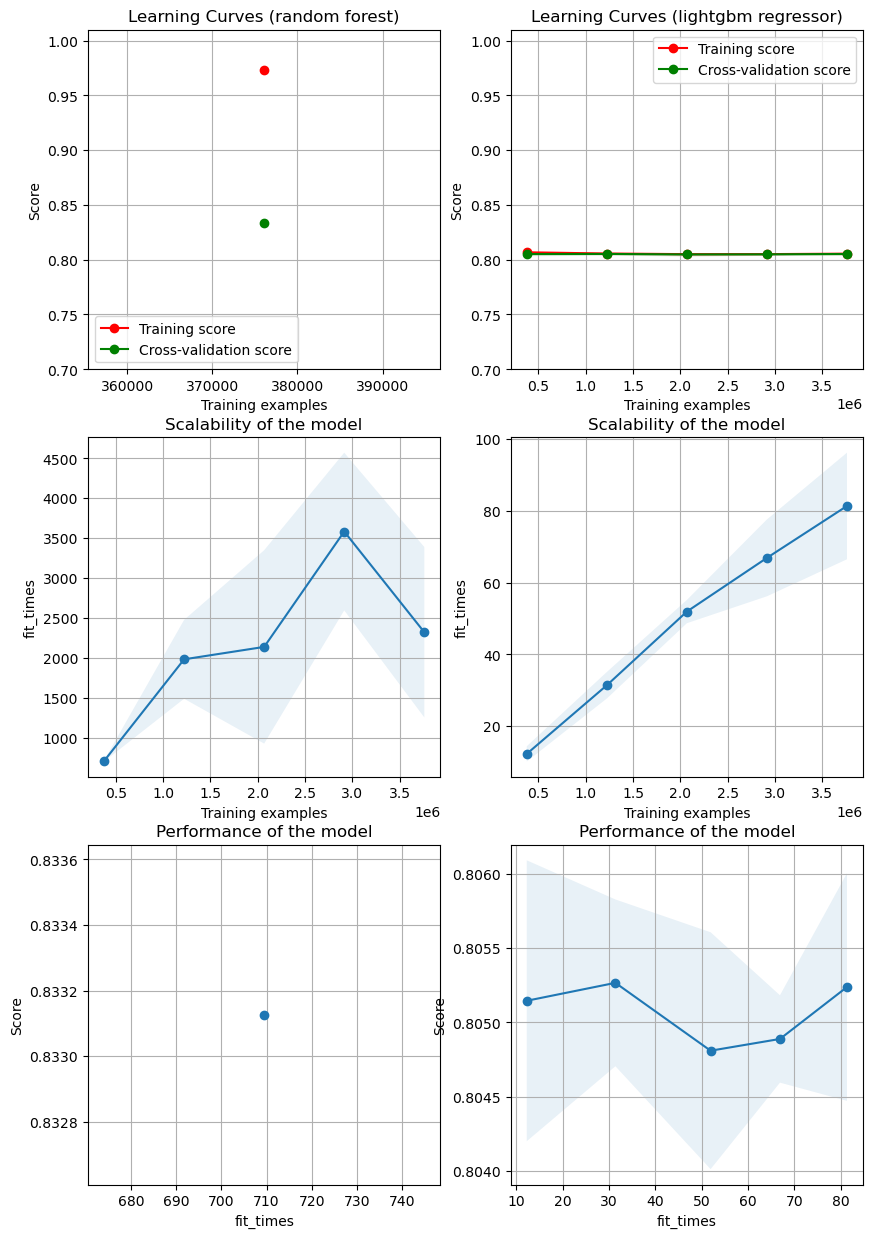

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
   
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (random forest)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = RandomForestRegressor()
plot_learning_curve(
    estimator,
    title,
    X_train,
    y_train,
    axes=axes[:, 0],
    ylim=(0.7, 1.01),
    cv=cv,
    n_jobs=-1,
)

title = "Learning Curves (lightgbm regressor)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = LGBMRegressor()
plot_learning_curve(
    estimator, 
    title, 
    X_train, 
    y_train, 
    axes=axes[:, 1], 
    ylim=(0.7, 1.01), 
    cv=cv, 
    n_jobs=-1
)

plt.show()

# Optuna

## RF

In [7]:
def RF_objective(trial):
    max_depth = trial.suggest_int('max_depth', 3, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 1, 150)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 60)
    min_weight_fraction_leaf = trial.suggest_uniform('min_weight_fraction_leaf', 0.0, 0.5)
    max_features = trial.suggest_uniform('max_features', 0.2, 1.0)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 1000)
    n_estimators =  trial.suggest_int('n_estimators', 50, 500)
    criterion = trial.suggest_categorical('criterion', ['absolute_error', 'squared_error'])
   
    model = RandomForestRegressor(max_depth = max_depth, 
                                  min_samples_split = min_samples_split,
                                  min_samples_leaf = min_samples_leaf,
                                  min_weight_fraction_leaf = min_weight_fraction_leaf,
                                  max_features = max_features,
                                  max_leaf_nodes = max_leaf_nodes,
                                  n_estimators = n_estimators,
                                  n_jobs=-1,
                                  random_state=1215,
                                  criterion=criterion)
    
    model.fit(X_train, y_train)    
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    mae_mean = score.mean()

    return mae_mean
    
#Execute optuna and set hyperparameters
RF_study = optuna.create_study(direction='maximize')
RF_study.optimize(RF_objective, n_trials=50)

#Create an instance with tuned hyperparameters
optimized_RF = RandomForestRegressor(max_depth = RF_study.best_params['max_depth'], 
                                     min_samples_split = RF_study.best_params['min_samples_split'],
                                     min_samples_leaf = RF_study.best_params['min_samples_leaf'],
                                     min_weight_fraction_leaf = RF_study.best_params['min_weight_fraction_leaf'],
                                     max_features = RF_study.best_params['max_features'],
                                     max_leaf_nodes = RF_study.best_params['max_leaf_nodes'],
                                     n_estimators = RF_study.best_params['n_estimators'],
                                     criterion = RF_study.best_params['criterion'],
                                     n_jobs=-1, 
                                     random_state=25)

[I 2022-10-12 19:19:24,394] A new study created in memory with name: no-name-e01eedc8-25d1-4393-99d9-8e9ec790ad21
[W 2022-10-12 19:21:36,362] Trial 0 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "c:\Users\nehcr\miniconda3\envs\deeplearn\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\nehcr\AppData\Local\Temp\ipykernel_19140\2801461583.py", line 22, in RF_objective
    model.fit(X_train, y_train)
  File "c:\Users\nehcr\miniconda3\envs\deeplearn\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "c:\Users\nehcr\miniconda3\envs\deeplearn\lib\site-packages\joblib\parallel.py", line 1056, in __call__
    self.retrieve()
  File "c:\Users\nehcr\miniconda3\envs\deeplearn\lib\site-packages\joblib\parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "c:\Users\nehcr\miniconda3\envs\d

## LGBM

In [14]:
# random sampler
sampler = TPESampler(seed=10)

# define function
def lgbm_objective(trial):
    lgbm_param = {
        'objective': 'regression',
        'verbosity': -1,
        "random_state": 42,
        'metric': 'mae', 
        'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
        'max_depth': trial.suggest_int('max_depth',3, 20),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.3, 1),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }


    # Generate model
    model_lgbm = LGBMRegressor(**lgbm_param)
    model_lgbm.fit(X_train, y_train,
                   eval_set=[(X_valid, y_valid)],
                   verbose=0, early_stopping_rounds=25)
                           
    # 평가 지표 mae                     
    score = cross_val_score(model_lgbm, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    mae_mean = score.mean()

    return mae_mean

optuna_lgbm = optuna.create_study(direction='maximize', sampler=sampler)

# * n_trials의 경우 optuna를 몇번 실행하여 hyper parameter를 찾을 것인지를 정한다.
# 50으로 설정해도 유의미한 값이 나온다.
optuna_lgbm.optimize(lgbm_objective, n_trials=30)

#Create an instance with tuned hyperparameters
optimized_lgbm = LGBMRegressor(objective='regression',
                               verbosity=-1,
                               random_state=42,
                               metric='mae',
                               num_leaves=optuna_lgbm.best_params['num_leaves'],
                               colsample_bytree=optuna_lgbm.best_params['colsample_bytree'],
                               reg_alpha=optuna_lgbm.best_params['reg_alpha'],
                               reg_lambda=optuna_lgbm.best_params['reg_lambda'],
                               max_depth=optuna_lgbm.best_params['max_depth'],
                               learning_rate=optuna_lgbm.best_params['learning_rate'],
                               n_estimators=optuna_lgbm.best_params['n_estimators'],
                               min_child_samples=optuna_lgbm.best_params['min_child_samples'],
                               subsample=optuna_lgbm.best_params['subsample'],
                               subsample_freq=optuna_lgbm.best_params['subsample_freq'],
                               max_bin=optuna_lgbm.best_params['max_bin'])
                               

[I 2022-10-12 01:08:08,848] A new study created in memory with name: no-name-434bf96f-b373-4848-922b-6eddcb2b2437
[I 2022-10-12 01:15:54,772] Trial 0 finished with value: -13.226870343298756 and parameters: {'num_leaves': 230, 'colsample_bytree': 0.41245116961564093, 'reg_alpha': 0.6336482349262754, 'reg_lambda': 7.488038825386118, 'max_depth': 11, 'learning_rate': 2.2324403996622945e-07, 'n_estimators': 674, 'min_child_samples': 78, 'subsample': 0.36774410255555345, 'subsample_freq': 1, 'max_bin': 406}. Best is trial 0 with value: -13.226870343298756.
[I 2022-10-12 01:36:59,414] Trial 1 finished with value: -11.46931935907308 and parameters: {'num_leaves': 756, 'colsample_bytree': 0.4023689597967487, 'reg_alpha': 0.5121922633857766, 'reg_lambda': 8.126209616521136, 'max_depth': 14, 'learning_rate': 0.00021405821746591817, 'n_estimators': 946, 'min_child_samples': 93, 'subsample': 0.7091820647693283, 'subsample_freq': 6, 'max_bin': 242}. Best is trial 1 with value: -11.46931935907308.


In [16]:
optimized_lgbm

LGBMRegressor(colsample_bytree=0.6478361602574069,
              learning_rate=0.007506057243261503, max_bin=328, max_depth=19,
              metric='mae', min_child_samples=24, n_estimators=2831,
              num_leaves=484, objective='regression', random_state=42,
              reg_alpha=0.9269756790052929, reg_lambda=0.8753460653023548,
              subsample=0.6924749447582821, subsample_freq=8, verbosity=-1)

In [15]:
optimized_lgbm = optimized_lgbm.fit(X_train, y_train,
                                eval_set=[(X_valid, y_valid)],
                                verbose=0, early_stopping_rounds=25)

pred = optimized_lgbm.predict(test)

# 결과 저장
sample_submission = pd.read_csv('./sample_submission.csv')
sample_submission['target'] = pred
sample_submission.to_csv("./submit.csv", index = False)

sample_submission

,id,target
0,TEST_000000,24.921107
1,TEST_000001,49.492975
2,TEST_000002,63.601079
3,TEST_000003,40.599471
4,TEST_000004,43.388980
...,...,...
291236,TEST_291236,45.395370
291237,TEST_291237,53.448100
291238,TEST_291238,33.026017
291239,TEST_291239,24.894716


In [22]:
# 시각화
optuna.visualization.plot_optimization_history(optuna_lgbm)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
              'y': [-13.226870343298756, -11.46931935907308, -13.046338414960488,
                    -13.228054810617635, -13.227375840924541, -12.347385382266001,
                    -13.21404577753847, -12.881595086561338, -6.625069336854909,
                    -7.983375721465981, -9.671651984080418, -4.483786413315434,
                    -4.5345989433724085, -5.267834834375072, -8.323709801706235,
                    -5.0397056562340214, -11.712552302381471, -13.197490299325036,
                    -4.633740555105136, -6.170421938960595, -8.662867988035961,
                    -5.408596193361909, -4.04192673355145, -4.011646917305518,
                    -4.029231915041017, -6.852223880411539, -12.34615944224552,
                    -5.177891552133042, -10.6756811506577, -13.209668118370757]},
             {'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
              'y': [-13.226870343298756, -11.46931935907308, -11.46931935907308,
                    -11.46931935907308, -11.46931935907308, -11.46931935907308,
                    -11.46931935907308, -11.46931935907308, -6.625069336854909,
                    -6.625069336854909, -6.625069336854909, -4.483786413315434,
                    -4.483786413315434, -4.483786413315434, -4.483786413315434,
                    -4.483786413315434, -4.483786413315434, -4.483786413315434,
                    -4.483786413315434, -4.483786413315434, -4.483786413315434,
                    -4.483786413315434, -4.04192673355145, -4.011646917305518,
                    -4.011646917305518, -4.011646917305518, -4.011646917305518,
                    -4.011646917305518, -4.011646917305518, -4.011646917305518]}],
    'layout': {'template': '...',
               'title': {'text': 'Optimization History Plot'},
               'xaxis': {'title': {'text': 'Trial'}},
               'yaxis': {'title': {'text': 'Objective Value'}}}
})

In [24]:
# 파라미터들관의 관계
optuna.visualization.plot_parallel_coordinate(optuna_lgbm)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'dimensions': [{'label': 'Objective Value',
                              'range': [-13.228054810617635, -4.011646917305518],
                              'values': [-13.226870343298756, -11.46931935907308,
                                         -13.046338414960488, -13.228054810617635,
                                         -13.227375840924541, -12.347385382266001,
                                         -13.21404577753847, -12.881595086561338,
                                         -6.625069336854909, -7.983375721465981,
                                         -9.671651984080418, -4.483786413315434,
                                         -4.5345989433724085, -5.267834834375072,
                                         -8.323709801706235, -5.0397056562340214,
                                         -11.712552302381471, -13.197490299325036,
                                         -4.633740555105136, -6.170421938960595,
                                         -8.662867988035961, -5.408596193361909,
                                         -4.04192673355145, -4.011646917305518,
                                         -4.029231915041017, -6.852223880411539,
                                         -12.34615944224552, -5.177891552133042,
                                         -10.6756811506577, -13.209668118370757]},
                             {'label': 'colsample_bytree',
                              'range': [0.4023689597967487, 0.9925752849411233],
                              'values': [0.41245116961564093, 0.4023689597967487,
                                         0.8044801690398071, 0.4542756095625444,
                                         0.8527886149179144, 0.9925752849411233,
                                         0.583275951005691, 0.926857985634915,
                                         0.7393042119329005, 0.7468818579294805,
                                         0.6323349202672073, 0.7571295548209397,
                                         0.6858571738134445, 0.6112061049325004,
                                         0.6853409465058441, 0.5053640194598674,
                                         0.8293628914008533, 0.7009701364776061,
                                         0.5482233302238646, 0.9005498911458947,
                                         0.7714270811757293, 0.5279127887276844,
                                         0.664502725117284, 0.6478361602574069,
                                         0.6518769048923156, 0.6590437658655065,
                                         0.5841358997005914, 0.6223114805411746,
                                         0.6558149329297939, 0.45745843411840514]},
                             {'label': 'learning_rate',
                              'range': [-7.718622083664503, -2.0060430045463957],
                              'ticktext': [1.91e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                                           0.001, 0.00986],
                              'tickvals': [-7.718622083664503, -7, -6, -5, -4, -3,
                                           -2.0060430045463957],
                              'values': [-6.6512201268149145, -3.669468095409203,
                                         -4.921170544673655, -7.718622083664503,
                                         -7.00990461368511, -4.4157701106146945,
                                         -5.42304692941017, -4.412980112222158,
                                         -2.127085125454144, -3.3083052882851094,
                                         -2.16959342846909, -2.0060430045463957,
                                         -2.4164672401858875, -3.0468212380385595,
                                         -2.705830842982942, -2.1633962259709243,
                                         -3.9401193605243505, -5.6991090066117795,
                                         -2.8831874826070645, -2.589936541599395,
                        

In [25]:
# 각 파라미터들의 상관관계
optuna.visualization.plot_contour(
    optuna_lgbm,
    params=[
        "max_depth",
        "num_leaves",
        "colsample_bytree",
        "subsample",
        "subsample_freq",
        "min_child_samples",
        "max_bin",
    ],
)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'type': 'scatter', 'xaxis': 'x', 'yaxis': 'y'},
             {'colorbar': {'title': {'text': 'Objective Value'}},
              'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                             'rgb(222,235,247)'], [0.25, 'rgb(198,219,239)'],
                             [0.375, 'rgb(158,202,225)'], [0.5,
                             'rgb(107,174,214)'], [0.625, 'rgb(66,146,198)'],
                             [0.75, 'rgb(33,113,181)'], [0.875, 'rgb(8,81,156)'],
                             [1.0, 'rgb(8,48,107)']],
              'connectgaps': True,
              'contours': {'coloring': 'heatmap'},
              'hoverinfo': 'none',
              'line': {'smoothing': 1.3},
              'reversescale': False,
              'showscale': True,
              'type': 'contour',
              'x': [0.37285864353952997, 0.4023689597967487, 0.41245116961564093,
                    0.4542756095625444, 0.45745843411840514, 0.5053640194598674,
                    0.5279127887276844, 0.5482233302238646, 0.583275951005691,
                    0.5841358997005914, 0.6112061049325004, 0.6223114805411746,
                    0.6323349202672073, 0.6478361602574069, 0.6518769048923156,
                    0.6558149329297939, 0.6590437658655065, 0.664502725117284,
                    0.6853409465058441, 0.6858571738134445, 0.7009701364776061,
                    0.7393042119329005, 0.7468818579294805, 0.7571295548209397,
                    0.7714270811757293, 0.8044801690398071, 0.8293628914008533,
                    0.8527886149179144, 0.9005498911458947, 0.926857985634915,
                    0.9925752849411233, 1.0220856011983421],
              'xaxis': 'x8',
              'y': [190.55, 205, 242, 269, 272, 290, 295, 307, 315, 326, 328, 329,
                    330, 342, 344, 358, 369, 370, 371, 386, 388, 406, 414, 428,
                    436, 457, 464, 473, 494, 508.45],
              'yaxis': 'y8',
              'z': [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, nan, -9.671651984080418,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan], [nan, -11.46931935907308,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, -12.34615944224552, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    -12.881595086561338, nan, nan], [nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, -5.177891552133042, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, -6.625069336854909, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    -12.347385382266001, nan], [nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, na

In [26]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(optuna_lgbm)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [num_leaves (IntDistribution):
                                0.015572080777160699<extra></extra>, subsample_freq
                                (IntDistribution):
                                0.018928259906487343<extra></extra>, max_bin
                                (IntDistribution):
                                0.019271213897713666<extra></extra>, subsample
                                (FloatDistribution):
                                0.022308961713362482<extra></extra>,
                                colsample_bytree (FloatDistribution):
                                0.05698285834880884<extra></extra>, reg_lambda
                                (FloatDistribution):
                                0.08445811534027603<extra></extra>,
                                min_child_samples (IntDistribution):
                                0.0884635156536371<extra></extra>, reg_alpha
                                (FloatDistribution):
                                0.09671676339770045<extra></extra>, max_depth
                                (IntDistribution):
                                0.10445243330760144<extra></extra>, n_estimators
                                (IntDistribution):
                                0.21339732785281426<extra></extra>, learning_rate
                                (FloatDistribution):
                                0.2794484698044377<extra></extra>],
              'marker': {'color': 'rgb(66,146,198)'},
              'orientation': 'h',
              'text': [0.02, 0.02, 0.02, 0.02, 0.06, 0.08, 0.09, 0.10, 0.10, 0.21,
                       0.28],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.015572080777160699, 0.018928259906487343,
                    0.019271213897713666, 0.022308961713362482,
                    0.05698285834880884, 0.08445811534027603, 0.0884635156536371,
                    0.09671676339770045, 0.10445243330760144, 0.21339732785281426,
                    0.2794484698044377],
              'y': [num_leaves, subsample_freq, max_bin, subsample,
                    colsample_bytree, reg_lambda, min_child_samples, reg_alpha,
                    max_depth, n_estimators, learning_rate]}],
    'layout': {'showlegend': False,
               'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Importance for Objective Value'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

## Catboost

In [8]:
cat_features = ['day_of_week', 'base_hour', 'lane_count', 'road_rating',
    'road_name', 'multi_linked', 'connect_code', 'maximum_speed_limit',
    'weight_restricted', 'height_restricted', 'road_type',
    'start_node_name', 'start_turn_restricted', 'end_node_name', 'end_turn_restricted', 'day_of_year',
    'holidays']

# cat feature to string
for col in cat_features:
    X_train[col] = X_train[col].astype(str)
    X_valid[col] = X_valid[col].astype(str)
    test[col] = test[col].astype(str)

In [9]:
# random sampler
sampler = TPESampler(seed=1215)

# define function
def CBR_objective(trial):

    CBR_param = {# prefix

                 # 'cat_features': cat_features,
                 'task_type' : 'GPU',
                 # 'bootstrap_type' : 'Poisson',
                 'random_seed' : 1215,
                 'iterations' : 3000,

                 # trial
                 'loss_function' : trial.suggest_categorical("loss_function", ['MAPE', 'Poisson', 'RMSE']),
                 'learning_rate' : trial.suggest_uniform("learning_rate", 1e-5, 3e-1),
                 'l2_leaf_reg' : trial.suggest_float("l2_leaf_reg", 0.0, 100),
                 'use_best_model' : trial.suggest_categorical("use_best_model", [True, False]),
                 'depth' : trial.suggest_int("depth", 2, 16),
                 # 'grow_policy' : trial.suggest_categorical("grow_policy", ['Depthwise', 'Lossguide']), # grow_policy symetric_tree일 경우 min_data_in_leaf가 버려야함
                 # 'min_data_in_leaf' : trial.suggest_int("min_data_in_leaf", 1, 100),

                 # Not trial
                 # 'one_hot_max_size': trial.suggest_int("one_hot_max_size", 1, 100),
                 # 'score_function' : trial.suggest_categorical("score_function", ['Cosine', 'L2', 'NewtonCosine', 'NewtonL2']), # grow policy Lossguide일 경우 cosine, newtoncosine 사용 불가
                 }

    # make Pool
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)
    test_pool = Pool(test, cat_features=cat_features)

    # Generate model
    model = CatBoostRegressor(**CBR_param)
    model.fit(train_pool, eval_set=[valid_pool], verbose=0, early_stopping_rounds=500)
                           
	# 평가지표 원하는 평가 지표가 있을 시 바꾸어 준다.
    mae = mean_absolute_error(y_valid, model.predict(X_valid))
    return mae

CBR_study = optuna.create_study(direction='minimize', sampler=sampler)
CBR_study.optimize(CBR_objective, n_trials=100)

#Create an instance with tuned hyperparameters
optimized_CBR = CatBoostRegressor(# cat_features=cat_features,
                                    task_type = 'GPU',
                                    # bootstrap_type = 'Poisson',
                                    random_seed = 1215,
                                    iterations = 10000,
                                    loss_function = CBR_study.best_params['loss_function'],
                                    learning_rate = CBR_study.best_params['learning_rate'],
                                    l2_leaf_reg = CBR_study.best_params['l2_leaf_reg'],
                                    use_best_model = CBR_study.best_params['use_best_model'],
                                    depth = CBR_study.best_params['depth'],
                                    # grow_policy = CBR_study.best_params['grow_policy'],
                                    # min_data_in_leaf = CBR_study.best_params['min_data_in_leaf'],
                                  )

[I 2022-10-13 11:27:39,309] A new study created in memory with name: no-name-7f2e4814-3b6d-428d-9f59-0fb486598f48


In [11]:
# 시각화
optuna.visualization.plot_optimization_history(CBR_study)

In [12]:
# 파라미터들관의 관계
optuna.visualization.plot_parallel_coordinate(CBR_study)

In [15]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(CBR_study)

In [11]:
# make Pool
train_pool = Pool(X_train, y_train, cat_features=cat_features)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)
test_pool = Pool(test, cat_features=cat_features)

optimized_CBR = CatBoostRegressor(# cat_features=cat_features,
                                    task_type = 'CPU',
                                    # bootstrap_type = 'Poisson',
                                    random_seed = 1215,
                                    iterations = 500,
                                    loss_function = 'RMSE',
                                    learning_rate = 0.023536589052477682,
                                    l2_leaf_reg = 35.751184830044046,
                                    use_best_model = False,
                                    depth = 14,
                                    grow_policy = 'Depthwise',
                                    min_data_in_leaf = 89
                                  )

optimized_CBR = optimized_CBR.fit(train_pool,
                                eval_set=[valid_pool],
                                verbose=100, early_stopping_rounds=100)

0:	learn: 15.6527055	test: 15.6396199	best: 15.6396199 (0)	total: 5.46s	remaining: 45m 24s
100:	learn: 6.4338129	test: 6.4094288	best: 6.4094288 (100)	total: 8m 41s	remaining: 34m 21s


KeyboardInterrupt: 

In [17]:
pred = optimized_CBR.predict(test)

# 결과 저장
sample_submission = pd.read_csv('./sample_submission.csv')
sample_submission['target'] = pred
sample_submission.to_csv("./submit.csv", index = False)

sample_submission

,id,target
0,TEST_000000,24.605852
1,TEST_000001,49.560212
2,TEST_000002,64.738509
3,TEST_000003,33.681827
4,TEST_000004,44.629502
...,...,...
291236,TEST_291236,45.469559
291237,TEST_291237,52.090599
291238,TEST_291238,35.150242
291239,TEST_291239,25.932321
